# P4 - Project Advanced Lane Finding

This is the jupyter notebook.

[here](./README.md) is the writeup file.

The goals / steps of this project are the following:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Apply a distortion correction to raw images.
1. Use color transforms, gradients, etc., to create a thresholded binary image.
1. Apply a perspective transform to rectify binary image ("birds-eye view").
1. Detect lane pixels and fit to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# bug with anaconda
import matplotlib
matplotlib.use('qt5agg')

# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
from imageio.plugins import ffmpeg
ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

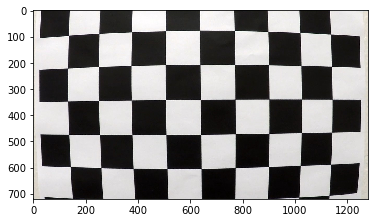

In [2]:
# examine the chessboard picture
img_example = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(img_example)

In [3]:
# Count number of intersections
nx = 9
ny = 6

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

### Add up the 3D intersections in all pictures into a 2D array and calculate the distortion

In [4]:

#%matplotlib qt



# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
#print('images: ', images)
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

# calculate the camera calibration
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

### plot an undistorted chessboard image

(720, 1280, 3)


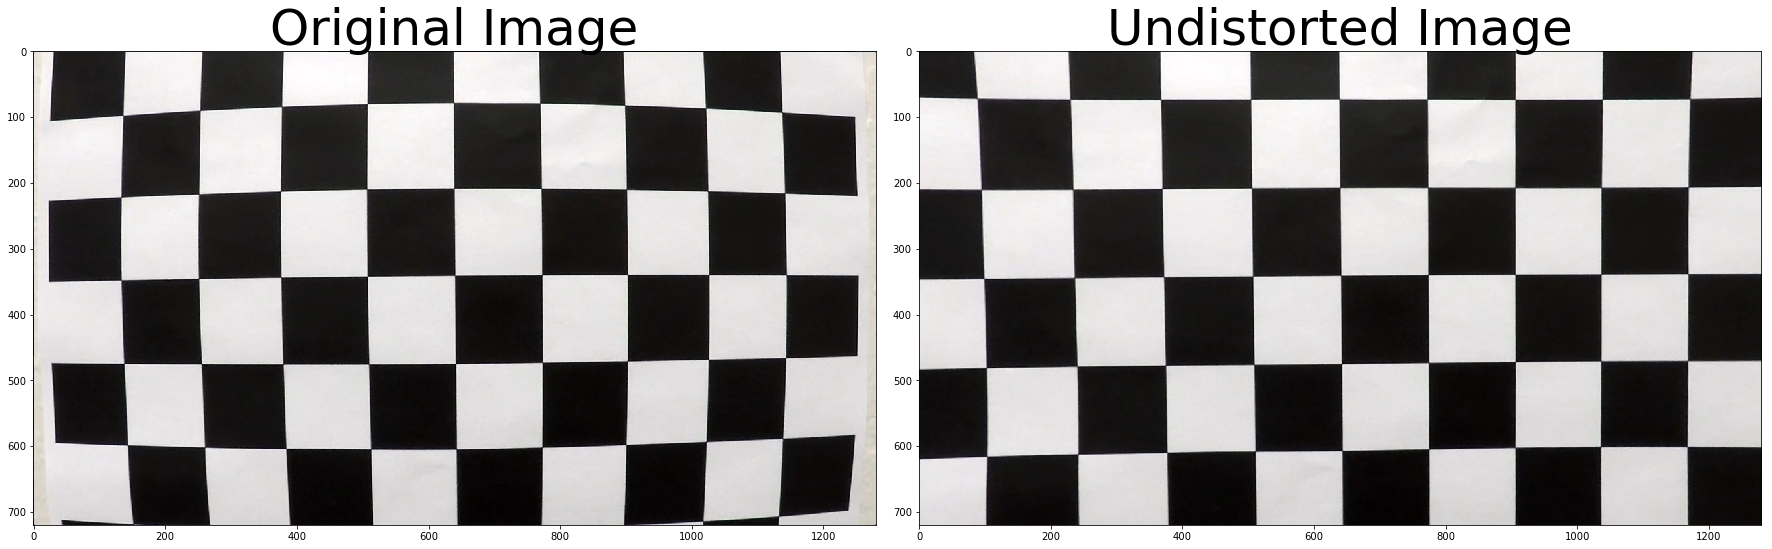

In [5]:

%matplotlib inline

undist_example = cv2.undistort(img_example, mtx, dist, None, mtx) 

def plottwoimages(image1,text1,image2,text2,fname):
    

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    if len(image1.shape) > 2:
        ax1.imshow(image1)
    else:
        ax1.imshow(image1,cmap='gray')
    ax1.set_title(text1, fontsize=50)
    print(image2.shape)
    if len(image2.shape) > 2:
        ax2.imshow(image2)
    else:
        ax2.imshow(image2,cmap='gray')
    ax2.set_title(text2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f.savefig(fname)

def plotoneimage(image1,text1,fname):
    

    f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(text1, fontsize=50)

    f.savefig(fname)

plottwoimages(img_example,'Original Image',undist_example,'Undistorted Image',"./output_images/an_undistorted_chessboard_image.png")


## 2. Apply a distortion correction to raw images. 

[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]
(720, 1280, 3)


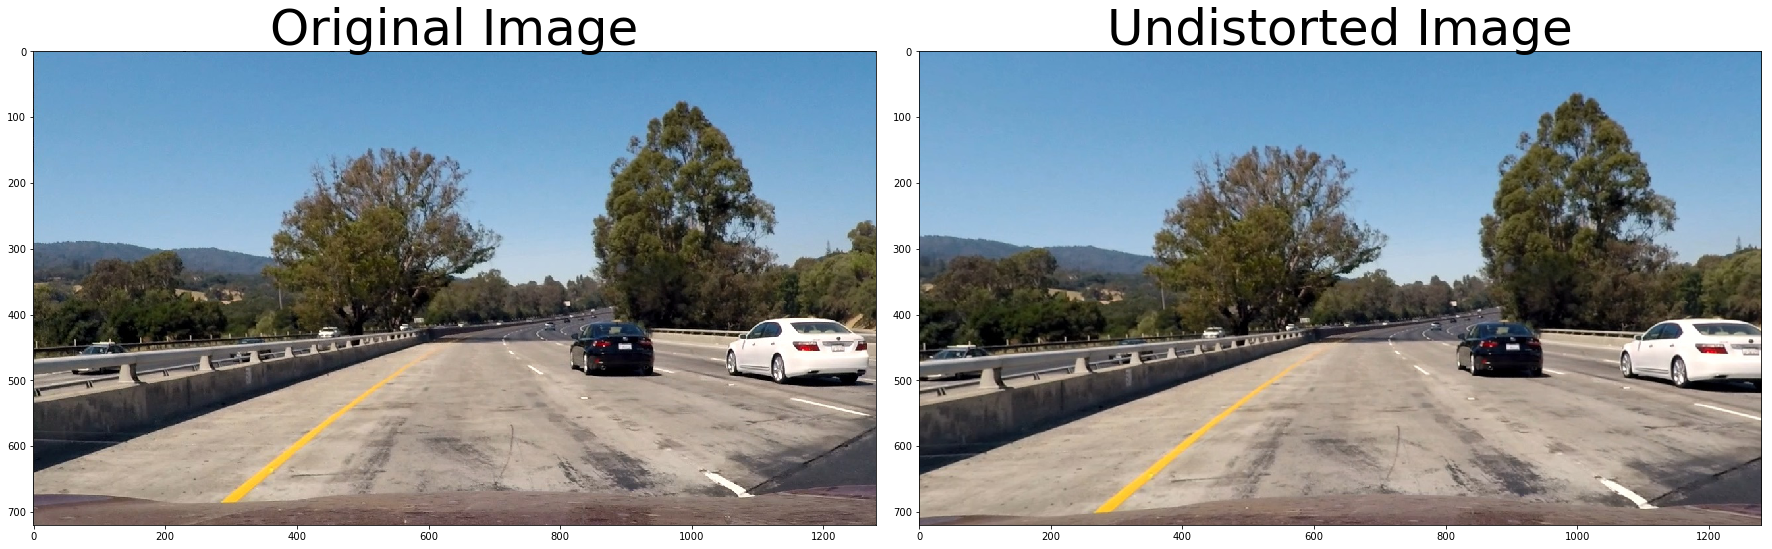

In [6]:
# plot an undistorted traffic image
%matplotlib inline

img_example2 = mpimg.imread('./test_images/test1.jpg')

undist_example2 = cv2.undistort(img_example2, mtx, dist, None, mtx) 

print(mtx, dist)
plottwoimages(img_example2,'Original Image',undist_example2,'Undistorted Image',"./output_images/an_undistorted_traffic_image.png")


## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

### Define Sobel functions for x,y, magnitude of gradient, direction and colour of the gradient

In [7]:
# using sobel to create a thresholded binary image

# defining functions that applies Sobel x or y, 
def abs_sobel_thresh(img, orient='x', thresh=(0, 255),sobel_kernel=3):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

#magnitude, or absolute value
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sbinary # Remove this line
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(angle)
    sbinary[(angle >= thresh[0]) & (angle <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sbinary # Remove this line
    return binary_output


def col_threshold(img, HLS_thres=(170, 255), HSV_thres=(200,255)):
    # 1) Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) find the s channel
    s = hls[:,:,2]
    # 3) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(s)
    sbinary[(s > HLS_thres[0]) & (s <= HLS_thres[1])] = 1
    
    # 4) Convert to HLC
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 5) find the s channel
    v = hsv[:,:,2]
    # 6) Create a binary mask where direction thresholds are met
    vbinary = np.zeros_like(v)
    vbinary[(v > HSV_thres[0]) & (v <= HSV_thres[1])] = 1  
    
    # 7) Combine the s and v channel
    binary_output = np.zeros_like(s)
    binary_output[(sbinary == 1) & (vbinary == 1)] = 1
    return binary_output


def apply_gradients(image):
    image = image.astype(np.uint8)
    ksize = 7 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=((0.65, 1.1)))
    col_binary = col_threshold(image, HLS_thres=(170, 255), HSV_thres=(200,255))
    #col_binary = col_threshold2(image)
        
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    binary = np.zeros_like(combined)
    binary[(col_binary > 0) | (combined > 0)] = 1
        
    return binary


def crop_image(image):
    image = image.astype(np.uint8)
    height = image.shape[0]
    width = image.shape[1]
    
    mask = np.zeros_like(image)

    vertices = np.array([[(200, 700), (600, 400), (750, 400), (1100, 700)]], dtype=np.int32)
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    
    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)

    return masked_image



### apply the functions to test images

(720, 1280)


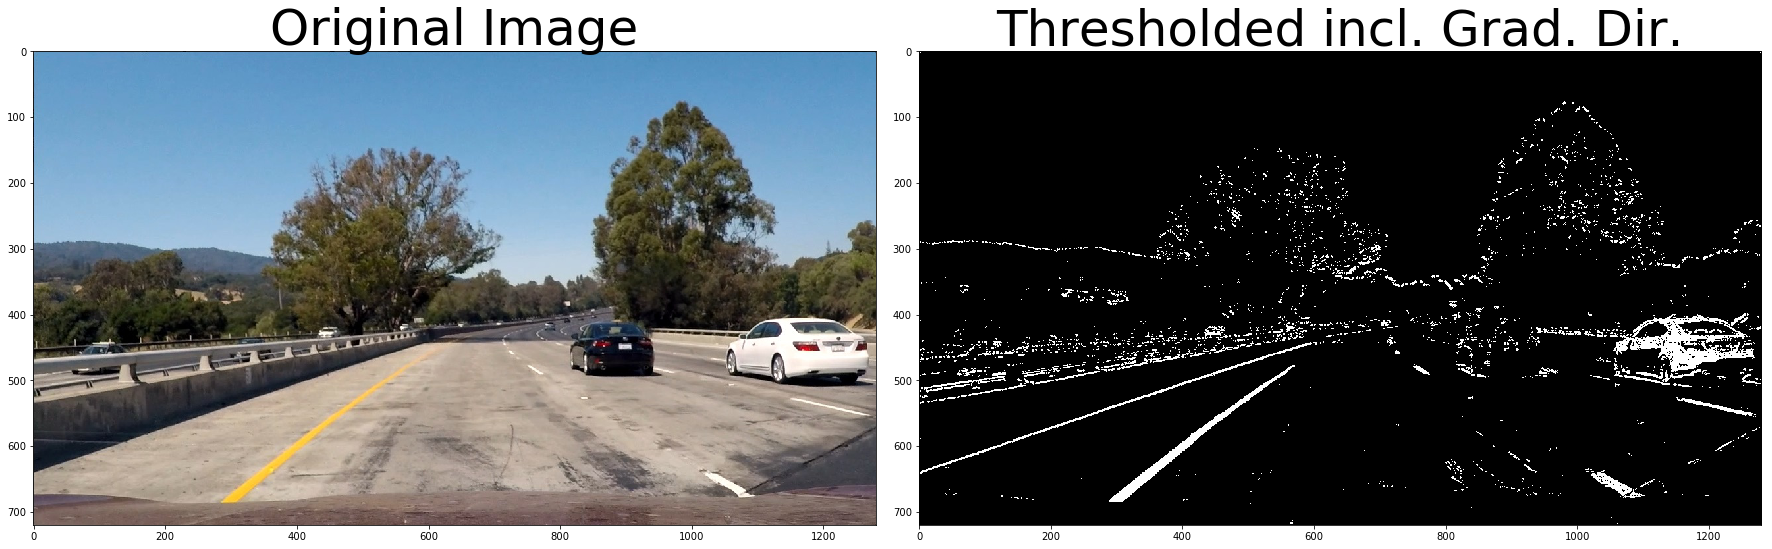

In [8]:
### apply the functions to test images

image = np.copy(img_example2)

# Run the function
combined_gradients = apply_gradients(img_example2)

# Plot the result
plottwoimages(img_example2,'Original Image',combined_gradients,"Thresholded incl. Grad. Dir.","./output_images/Thresholded_incl_Grad_Dir.png")



### Crop the mask to the region of interest

(720, 1280)
uint8


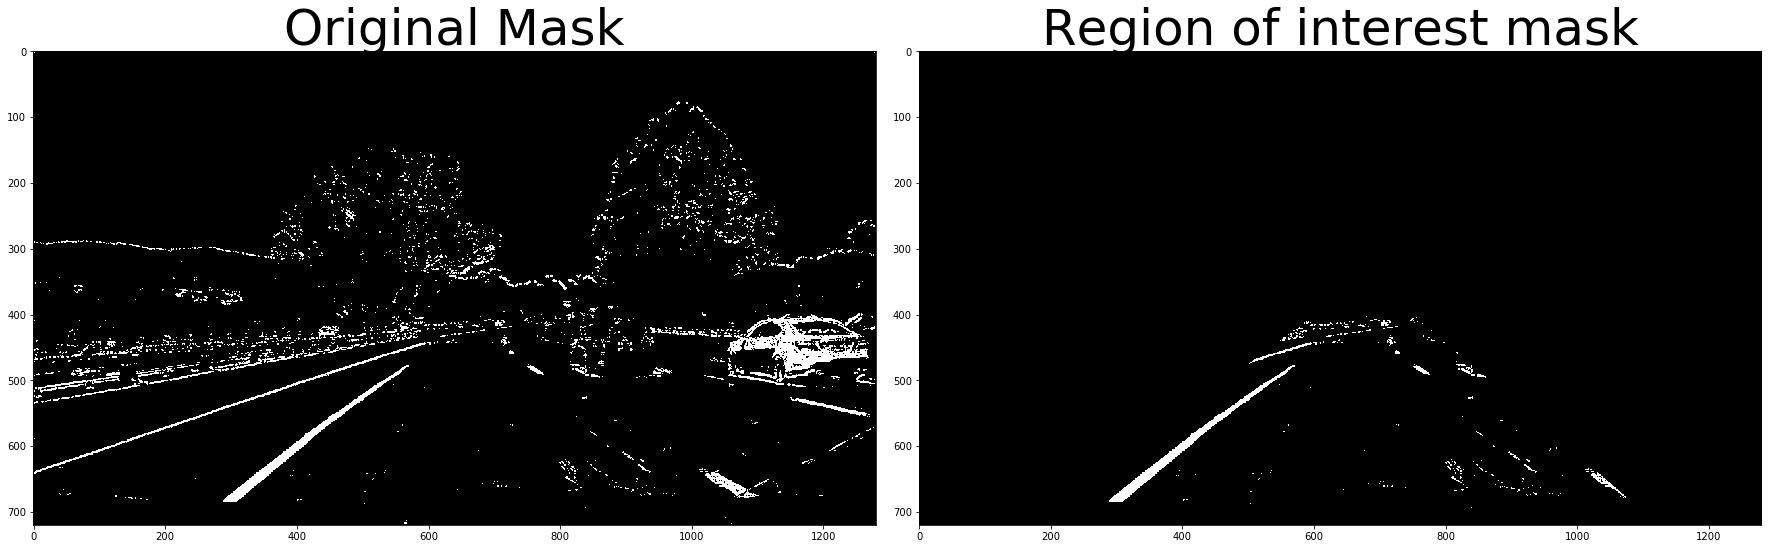

In [9]:
### apply the functions to test images

image = np.copy(img_example2)

# Run the function
crop_mask = crop_image(combined_gradients)


# Plot the result
plottwoimages(combined_gradients,'Original Mask',crop_mask,"Region of interest mask","./output_images/region_of_interest_mask.png")

print(image.dtype)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

### Define a warping function, adjust based on lines drawn on the images

In [10]:
def warp_coeff():

    src = np.float32([
        [250, 680],
        [1050, 680],
        [585, 455],
        [695, 455]
    ])

    dst = np.float32([
        [320, 700],
        [950, 700],
        [330, 0],
        [950, 0]
    ])
    return src,dst

def warp(img, src,dst):
    # Compute and apply perpective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped



### test warping on straight lines

(720, 1280, 3)


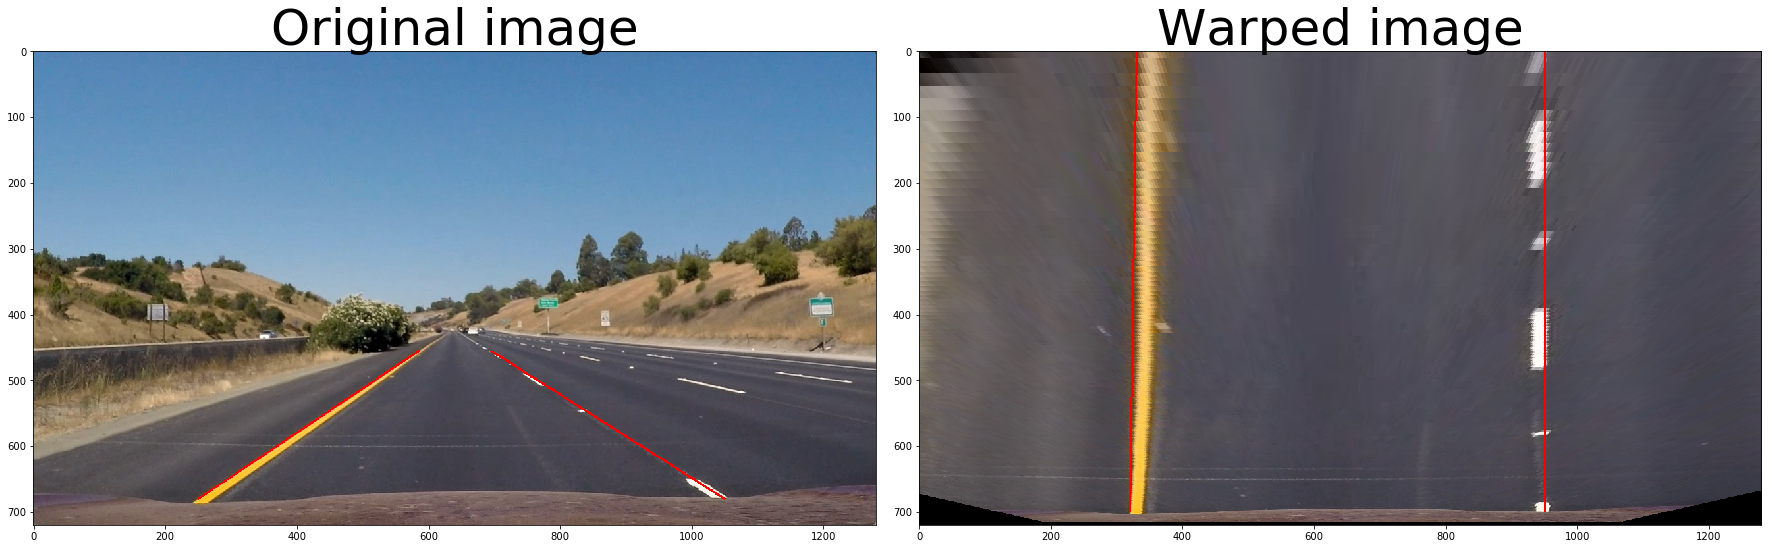

In [11]:
wsrc, wdst = warp_coeff()

image = mpimg.imread('test_images/straight_lines1.jpg')


# Run the function
warped = warp(image,wsrc,wdst)

# draw help lines
cv2.line(image,tuple(wsrc[0]),tuple(wsrc[2]),(255,0,0),2)
cv2.line(image,tuple(wsrc[1]),tuple(wsrc[3]),(255,0,0),2)

cv2.line(warped,tuple(wdst[0]),tuple(wdst[2]),(255,0,0),2)
cv2.line(warped,tuple(wdst[1]),tuple(wdst[3]),(255,0,0),2)

# Plot the result
plottwoimages(image,'Original image',warped,"Warped image","./output_images/warped_image.png")



### Test on a curved image mask

(720, 1280)


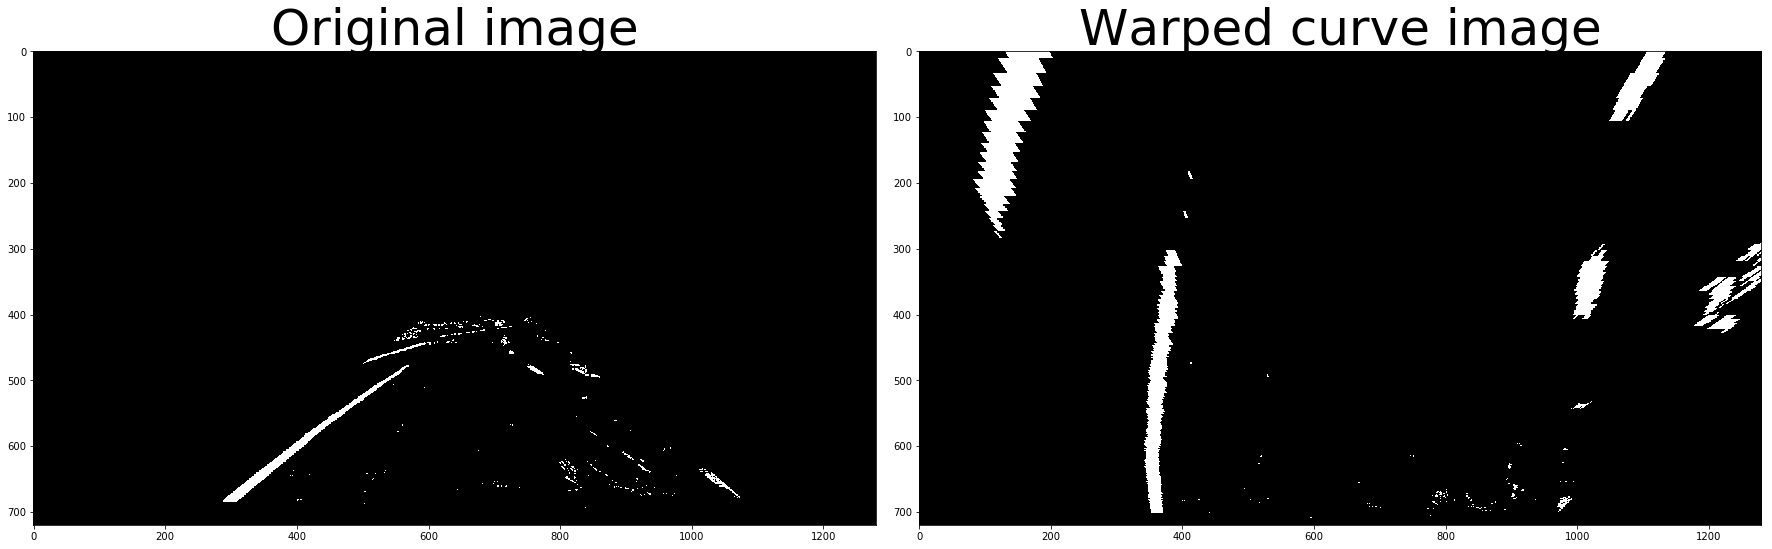

In [12]:

image = np.copy(crop_mask)

# Run the function
warped = warp(image,wsrc,wdst)

# Plot the result
plottwoimages(image,'Original image',warped,"Warped curve image","./output_images/warped_curved_image.png")




## 5. Detect lane pixels and fit to find the lane boundary.

### Plot the histogram of the warped image

(720, 1280)
uint8
360
1


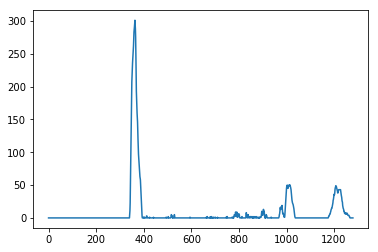

In [13]:

image = np.copy(warped)
print (image.shape)
print (image.dtype)
half_down = int(image.shape[0]/2)
print (half_down)
#plottwoimages(image,'Original image',image[int(image.shape[0]/2):,:],"Lower half image","./output_images/lower_half_image.png")
histogram = np.sum(image[half_down:,:], axis=0)
print(np.max(image))
plt.plot(histogram)
plt.savefig('./output_images/histogram.png')


### Sliding window from lecture notes

In [14]:
def sliding_windows(binary_warped):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = cv2.rectangle(out_img,(10,10),(200,200),(0,255,0), 5) 
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        #print('left:  ',(win_xleft_low,win_y_low),(win_xleft_high,win_y_high))
        #print('right: ',(win_xright_low,win_y_low),(win_xright_high,win_y_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx, leftx_base, rightx_base
    



### Plot the sliding windows, and the curves

(720, 1280, 3)


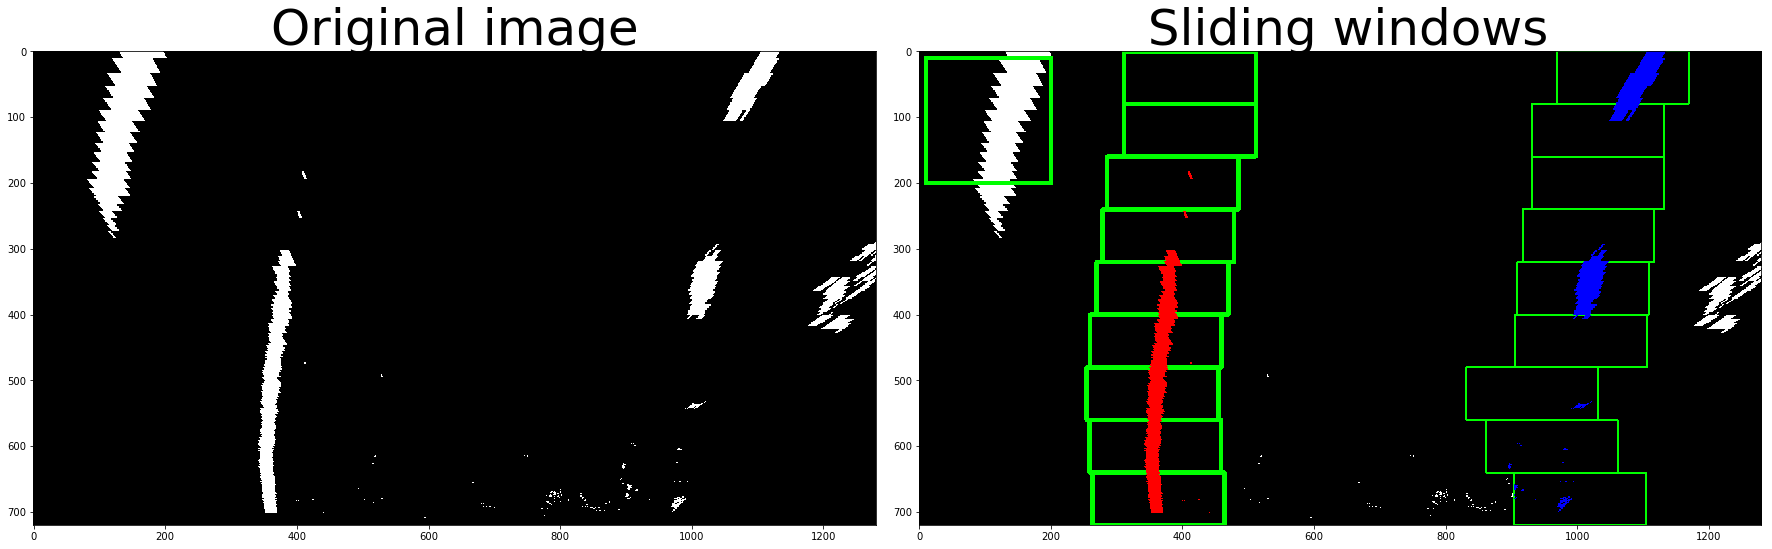

In [15]:

out_img,ploty,left_fitx,right_fitx,left_fit,right_fit,leftx,rightx,leftx_base,rightx_base = sliding_windows(warped)

# Plot the result
plottwoimages(warped,'Original image',out_img," Sliding windows","./output_images/sliding_windows.png")




### Plot the polyfit curve on top of the image

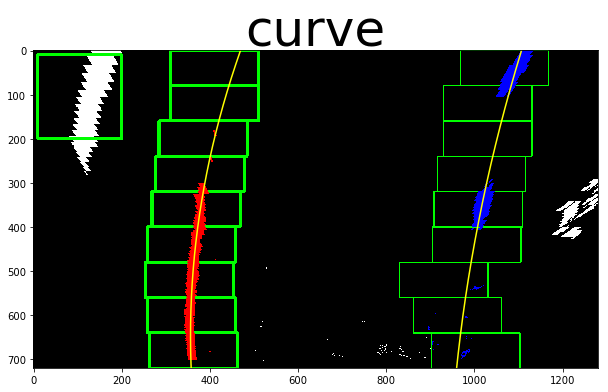

In [16]:

f, (ax1) = plt.subplots(1, 1, figsize=(12, 5))
f.tight_layout()
ax1.imshow(out_img)
ax1.plot(left_fitx,ploty,color='yellow')
ax1.plot(right_fitx,ploty,color='yellow')
ax1.set_title('curve', fontsize=50)

f.savefig("./output_images/sliding_windows_polyfit.png")

### Skip the sliding windows step once we know where the lines are

In [17]:
def find_in_margins(binary_warped,left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result, ploty, left_fitx, right_fitx, left_fit, right_fit



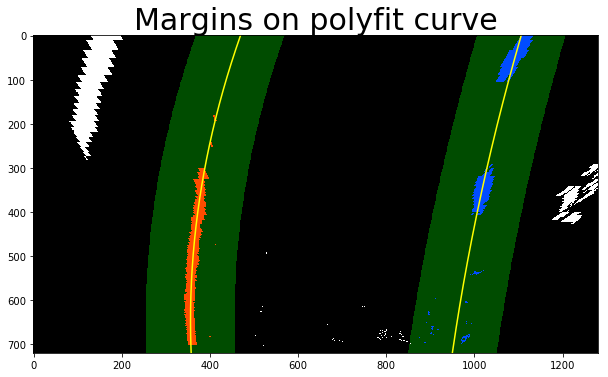

In [18]:

out_img, ploty, left_fitx, right_fitx, left_fit, right_fit = find_in_margins(warped,left_fit, right_fit)


f, (ax1) = plt.subplots(1, 1, figsize=(12, 5))
f.tight_layout()
ax1.imshow(out_img)
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')


ax1.set_title('Margins on polyfit curve', fontsize=30)

f.savefig("./output_images/margins_polyfit.png")




## 6. Determine the curvature of the lane and vehicle position with respect to center.

### Once again use the code from the lecture
#### Calculate in pixel space

In [19]:
def calculate_curve_in_pixel_space(ploty,left_fit,right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

In [20]:
print('Calculated curve:  ',calculate_curve_in_pixel_space(ploty,left_fit,right_fit))

Calculated curve:   (1848.8673250898687, 5170.132411669998)


#### Calculate in real space

In [21]:
def calculate_curve_in_real_space(ploty, leftx, rightx):

    # Define conversions in x and y from pixels space to meters,
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    leftx = np.array(leftx, dtype=np.float32)
    rightx = np.array(rightx, dtype=np.float32)
    left_fit_cr = np.polyfit(leftx*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(rightx*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

In [22]:

left_curverad, right_curverad = calculate_curve_in_real_space(ploty, leftx, rightx)

print('Calculated curve in meters,  left: {:2f} right: {:2f}'.format(left_curverad, right_curverad))

Calculated curve in meters,  left: 194.245808 right: 523.050836


#### Vehicle position with respect to center

In [23]:

def calculate_offset(image, leftx_base, rightx_base):
    center = img.shape[1]/2
    lane_center = (leftx_base + rightx_base) / 2
    xm_per_pix = 3.7/700
    offset = (center - lane_center) * xm_per_pix
    return offset

In [24]:
image = np.copy(img_example2)
offset = calculate_offset(image,leftx_base,rightx_base)
print('vehicle position with respect to center: {:2f} m\n'.format( offset))

vehicle position with respect to center: -0.227286 m



## 7. Warp the detected lane boundaries back onto the original image.
### Once again use the code from the lecture

In [25]:
def lines_back_down(image, warped, wsrc, wdst, ploty, left_fitx, right_fitx):
    Minv = cv2.getPerspectiveTransform(wdst, wsrc)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result



#plt.imshow(result)

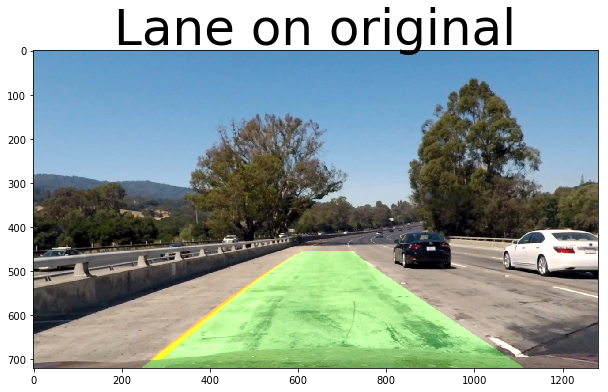

In [26]:
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
result = lines_back_down(undistorted, warped, wsrc, wdst, ploty, left_fitx, right_fitx)


f, (ax1) = plt.subplots(1, 1, figsize=(12, 5))
f.tight_layout()
ax1.imshow(result)
ax1.set_title('Lane on original', fontsize=50)

f.savefig("./output_images/lane_on_original.png")

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [27]:
# using distrotion, cropping and other variable from cells above

def process_image(image):
    # processing pipeline
    # 1) undistort image
    #print(mtx, dist)
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    # 2) apply the gradiend threshold on the image
    graded = apply_gradients(image)
    # 3) crop the image
    crop_mask = crop_image(graded)
    # 4) warp the image
    wsrc, wdst = warp_coeff()
    warped = warp(crop_mask,wsrc,wdst)
    # 5) calculate the polyfit lines
    out_img,ploty,left_fitx,right_fitx,left_fit,right_fit,leftx,rightx,leftx_base,rightx_base = sliding_windows(warped)
    #out_img, ploty, left_fitx, right_fitx, left_fit, right_fit = find_in_margins(warped,left_fit, right_fit)
    # 6) calculate_curve_in_real_space
    left_curverad, right_curverad = calculate_curve_in_real_space(ploty, leftx, rightx)
    # 7) Vehicle position with respect to center
    offset = calculate_offset(image,leftx_base,rightx_base)
    # 8) add text about curve and offset to the image
    cv2.putText(undistorted, 'Left radius:  {:25.2f} m'.format(left_curverad), (400,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(undistorted, 'Right radius: {:25.2f} m'.format(right_curverad),(400,90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(undistorted, 'Offset:       {:25.2f} m'.format(offset), (400,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    # 8) plot lane back at the original image
    result = lines_back_down(undistorted, warped, wsrc, wdst, ploty, left_fitx, right_fitx)
    

    
    return result

(720, 1280, 3)


255

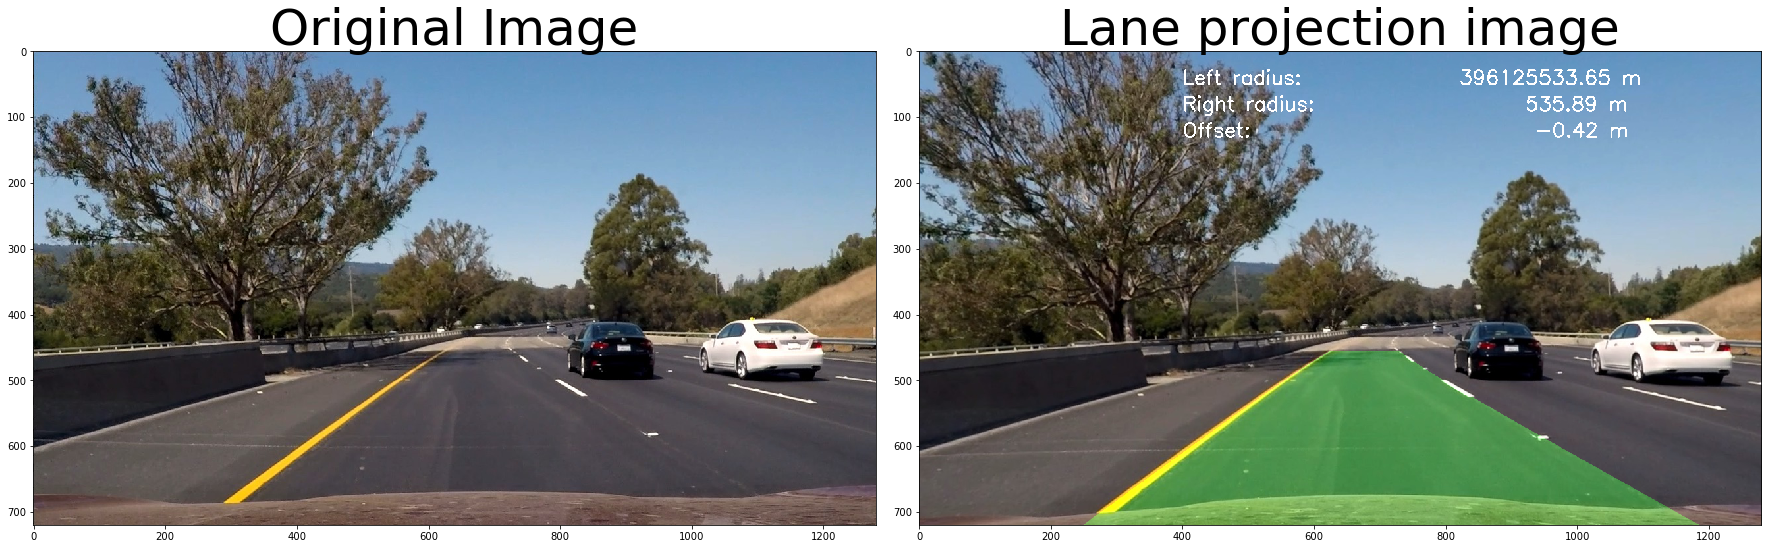

In [28]:
# plot an undistorted traffic image
%matplotlib inline

img_example3 = mpimg.imread('./test_images/test6.jpg')

new_example3 = process_image(img_example3) 

plottwoimages(img_example3,'Original Image',new_example3,'Lane projection image',"./output_images/lane_projection_image.png")

np.max(new_example3)


In [29]:
video_output = './output_images/project_video_projected.mp4'
clip1 = VideoFileClip("./project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_projected.mp4
[MoviePy] Writing video ./output_images/project_video_projected.mp4


100%|█████████▉| 1260/1261 [05:27<00:00,  3.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_projected.mp4 

CPU times: user 17min 39s, sys: 1min 42s, total: 19min 21s
Wall time: 5min 28s


In [30]:
video_output = './output_images/challenge_video_projected.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/challenge_video_projected.mp4
[MoviePy] Writing video ./output_images/challenge_video_projected.mp4


100%|██████████| 485/485 [02:02<00:00,  4.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/challenge_video_projected.mp4 

CPU times: user 6min 39s, sys: 38 s, total: 7min 17s
Wall time: 2min 2s
